### Imports

In [31]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from IPython.display import display,HTML


# SKLearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge , Lasso

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Plotly
import plotly.express as px

# Init cufflinks
#making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

#### Pipeline funtions

In [32]:
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred)
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'y')
    
    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    return auc

In [33]:
def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred)

    # Check recall
    recall = recall_score(labels_test , pred)

    # Check F1 score
    F1 = f1_score( labels_test , pred)

    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))
    
    auc = aoc_arc_curve(pred, labels_test)
    
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}

#### Loading data

In [34]:
# Loading data using pandas
penguins = sns.load_dataset('penguins')

In [35]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [36]:
# Dropping rows with NA or NaN values
penguins.dropna(inplace =True)

In [37]:
# Creating a features and labels
feature = penguins.drop(['island','body_mass_g'], axis=1 )
label = penguins['body_mass_g'] 

In [38]:
# The categorical variables are: feature[['species','sex']]

# Pass the categorical variables to OneHotEncoder
feature = pd.get_dummies(data=feature, columns=['species','sex'], drop_first=True)

# Split data into training and test sets
feature_train, feature_test, label_train, label_test = train_test_split(feature, label)

#### Correlation Matrix

<AxesSubplot:>

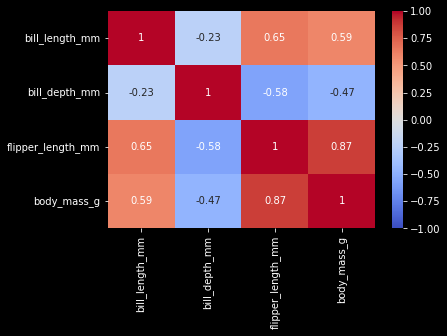

In [39]:
# Correlation data 
corr = penguins.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

### 11. Pipeline

In [40]:
# Setting up a pipeline
pipe = make_pipeline(StandardScaler(),
                     SelectKBest(f_regression),
                     Ridge()
                    )

In [41]:
# Parameter grid to search over using grid search
params={
    'selectkbest__k':[1,3,5,7,9,11,13],
    'ridge__fit_intercept' : [True,False],
    'ridge__alpha' :[5,10],
    'ridge__solver' :['svd', 'cholesky', 'lsqr' ,'sparse_cg', 'sag', 'saga']
}

# Set up the grid search
gs = GridSearchCV(pipe,params,n_jobs=-1,cv=5)

# Fit gs to training data
gs_results = gs.fit(feature_train , label_train)

In [42]:
# Find best fit
print(f'Best score: {gs_results.best_score_}')
print(f'Best parameters: \n{gs_results.best_params_}')

Best score: 0.8645038699253031
Best parameters: 
{'ridge__alpha': 5, 'ridge__fit_intercept': True, 'ridge__solver': 'svd', 'selectkbest__k': 5}


In [43]:
# building a dataframe from cross validation data
df_cv_scores=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

# selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
              'split3_test_score', 'split4_test_score', 'mean_test_score',\
              'std_test_score', 'rank_test_score']].iplot(kind='bar')



Score: 0.8498669156509866


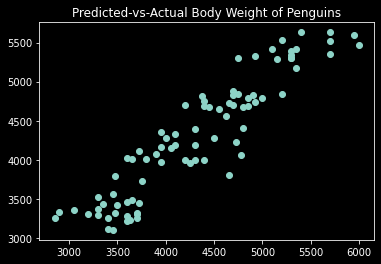

In [44]:
# Get score
print(f'\nScore: {gs.score(feature_test, label_test)}')

# Predict results
label_preds = gs.predict(feature_test)

# Plotting predicted body weights vs actual body weights of penguins
plt.scatter(label_test,label_preds)
plt.title('Predicted-vs-Actual Body Weight of Penguins')
plt.show()

